# Preamples

## Libraries

In [ ]:
#import numba as nb
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from matplotlib.patches import Ellipse

## Functions

In [ ]:
# @title
def paceka(x, B=1.0,C=0.5,D=0.5,E=1.0):
  mu = D * np.sin( \
                  C * np.arctan( \
                                B *( \
                                 (1-E) * \
                                     x + \
                                      (E) * \
                                     np.arctan(B* x)\
                                     )\
                                 )
                  );
  slip = x
  return mu

def noise_maker(axis, sd):
  #np.random.seed(3)
  n = np.random.normal(0, sd, axis.shape)
  #n = np.random.uniform(low=-sd, high=sd, size=axis.shape)
  noisy_axis = axis + n
  return noisy_axis

def corr_calcs(mu, slip):

  coarsity = .01

  rng = np.max(mu)-np.min(mu)
  sd_mu_data = np.std(mu)

  sd_range = np.arange(0, 0.11, coarsity) #0.171 for uniform; for gaussian 0.091
  #sd_range_by_rng = np.arange(0, 1, coarsity)

  sd_len = len(sd_range)

  mu_normalized = mu/np.max(mu)

  epoch = 500000

  cost = np.zeros((len(sd_range)*epoch, 3))

  k = 0
  for i in np.arange(epoch):

    for j in np.arange(sd_len):

      sd = sd_range[j]

      #sd_rng = sd*rng
      #sd_sd = sd*sd_mu_data

      mu_noisy = noise_maker(mu, sd)
      #mu_noisy_normalized = noise_maker(mu_normalized, sd)
      #mu_noisy_by_rng = noise_maker(mu, sd_rng)
      #mu_noisy_by_sd = noise_maker(mu, sd*sd_mu_data)

      cost[k, 0] = i
      #cost[k, 1] = sd_rng
      #cost[k, 2] = sd_sd

      cost[k, 1] = sd

      cost[k, 2] = np.corrcoef(mu, mu_noisy)[0][1]
      #cost[k, 5] = np.corrcoef(mu_normalized, mu_noisy_normalized)[0][1]

      #cost[k, 3] = np.std(cost[0:k, 2])/np.mean(cost[0:k, 2])
      #cost[k, 6] = np.corrcoef(mu, mu_noisy_by_rng)[0][1]
      #cost[k, 7] = np.corrcoef(mu, mu_noisy_by_sd)[0][1]
      if cost[k,2]<0:
        print(i, sd)
        return cost

      if cost[k, 2] >1:
        print(i, sd, cost[k, 2])

      k = k+1


    if i%10000 == 0:
      print(i)
    #print(np.std(cost[0:k, :], 0)/np.mean(cost[0:k], 0))'''
      #print('')
    '''if (i!=0) and (i%1000 == 0):
      np.save('costs_100gaussian.npy', cost[0:k,:])
      files.download('costs_100gaussian.npy')'''

  return cost

def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

# Introduction

This study is about using Physics-Intuitive Neural Networks (PINN) to denoise teh data using syntethic data based on the physiscs of the problem.

In anotehr words, this problem can be translated as an inverse problem, which noisy data, and teh shape of the function were given and teh goal is to find the original function o fthe denoised data.

A unique approach was developed to produce noisy training data that contain enough noise and pattern for the algorithm to denoise actual data from experiments. Also Pacejka tire model was selected as the case study fro this methodology.

This study contains three parts:
1. Producing noisy data
2. Design and a training PINN
3. Train a ML that predict the whole range of the function using only a snapshot of the data

## FAQ
**Is it unique approach?** No one has done it yet! that's why we need to IP it

**Why sytectic data?** because it's cheaper and we can cover more operational conditions, having labled data.

**Why only use $\mu$ and slip curve?** Because any other operational and enviromental condtion that can change the tire stiffness, needs to change this curve as well. In fact, we are using this curve as a proxy to sens other states as well

**Why PINN?** Because they can reach to solutions for a highly non-linear equation under different initial and boundry conidtions in much less epochs and by sonsidering the expected behavior from the physics.

# part 1: What we know about our noise?

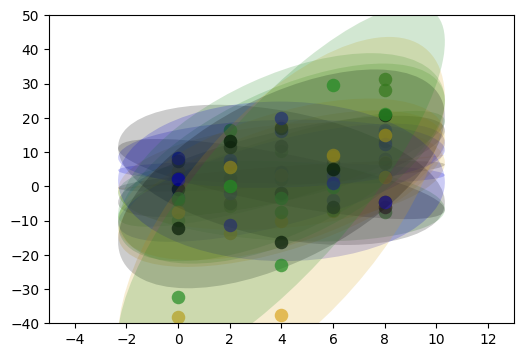

In [ ]:
# @title
x_example = np.arange(0,10, 2)
y_example = x_example

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim([-5,13])
ax.set_ylim([-40,50])
col = ['mediumblue', 'goldenrod', 'black','forestgreen','mediumblue', 'goldenrod', 'black','forestgreen','mediumblue', 'goldenrod', 'black','forestgreen','mediumblue', 'goldenrod', 'black','forestgreen','mediumblue', 'goldenrod', 'black','forestgreen']
k=0
for i in np.arange(0,20, 1):
  y_example_noisy = noise_maker(y_example, i)
  #plt.plot(x_example, y_example_noisy, 'o')

  cov = np.cov(x_example, y_example_noisy)
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
  w, h = 2 * 2 * np.sqrt(vals)
  ell = Ellipse(xy=(np.mean(x_example), np.mean(y_example_noisy)),
              width=w, height=h,
              angle=theta, alpha=0.2)#, color='black'
  ell.set_facecolor(col[k]) # reference the colour for each factor (defined by lab)
  ax.add_artist(ell)
  ax.scatter(x_example, y_example_noisy,
                  #label=lab, # use labels provided above
                  c=col[k], # use colors provided above
                  lw = 0, #remove the outer line of each point
                  alpha=0.7, # increase transparency of points
                  s=95) # increase the size of points
  k = k+1

## How much noise?
the idea is to find maximum amount of the noise that a system cantolerate. As the above figure shows, some systems looses their orders, when exposing to high levelof the noise.

This idea coming from collective behavior and statistical mechanics research.

As teh previous exaple shows, system can still tollerate some level of teh nosie and keep its slope, but after a while it change its phase and being transformed to another system.

For this study I choose the coorelation between *clean data* and *noisy data* as a metric for order of the system.

I decided to work with only positive values since teh negative one shows anotehr system and if it's happened in relaity it means our sensors do not working.

I already ran the below code and saved the results as `costs_uniform_trim.npy` in the folder. So I will do the rest of teh analysises on that data.

In [ ]:
# This code was really used using uniform noise
slip = np.arange(0,101)/100
mu = paceka(slip, B=1.0,C=0.5,D=0.5,E=1.0)

#costs = []
#costs = corr_calcs(mu, slip)
#np.save('costs_normal_trim.npy', costs)
#files.download('costs_normal_trim.npy')
print('done')

done


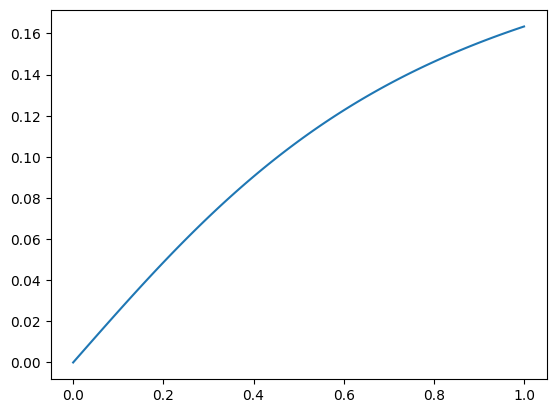

In [ ]:
plt.plot(slip, mu)

In [ ]:
#np.save('costs_normal_trim_1_100_500k.npy', costs)
#files.download('costs_normal_trim_1_100_500k.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analyzing the saved data

In [ ]:
#Data1 = pd.DataFrame(np.load('costs_uniform_trim.npy'))
Data2 = pd.DataFrame(np.load('costs_normal_trim.npy'))

#Data3 = pd.DataFrame(np.load('costs_normal_trim_1_100_500k.npy'))
#Data4 = pd.DataFrame(np.load('costs_normal_trim_1_100.py'))

In [ ]:
Data2.head()

,0,1,2
0,0.0,0.000,1.000000
1,0.0,0.001,0.999805
2,0.0,0.002,0.998827
3,0.0,0.003,0.998289
4,0.0,0.004,0.996746


In [ ]:
Data2.describe()

,0,1,2
count,9.100000e+06,9.100000e+06,9.100000e+06
mean,4.999950e+04,4.500000e-02,7.420165e-01
std,2.886752e+04,2.626785e-02,1.786376e-01
min,0.000000e+00,0.000000e+00,7.903670e-02
25%,2.499975e+04,2.200000e-02,5.920854e-01
50%,4.999950e+04,4.500000e-02,7.399128e-01
75%,7.499925e+04,6.800000e-02,9.110482e-01
max,9.999900e+04,9.000000e-02,1.000000e+00


In [ ]:
Data2[Data2.iloc[:,1] == .001]

,0,1,2
1,0.0,0.001,0.999805
92,1.0,0.001,0.999780
183,2.0,0.001,0.999866
274,3.0,0.001,0.999810
365,4.0,0.001,0.999809
...,...,...,...
9099546,99995.0,0.001,0.999809
9099637,99996.0,0.001,0.999779
9099728,99997.0,0.001,0.999780
9099819,99998.0,0.001,0.999810


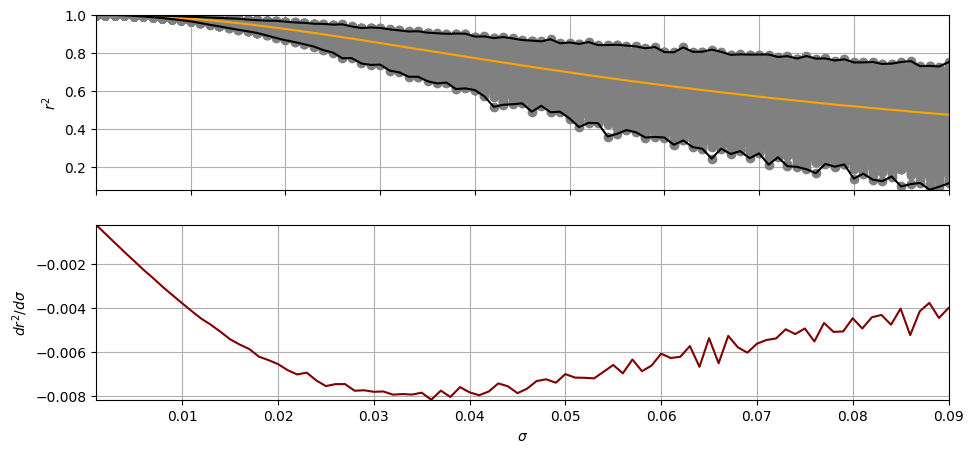

In [ ]:
plt.figure(figsize=(11,5))
plt.subplot(211)
plt.plot(Data2.iloc[:,1], Data2.iloc[:,2], 'o', c = 'gray')
plt.plot(Data2.groupby(1).mean().index, Data2.groupby(1).mean().iloc[:,1], c = 'orange')
plt.plot(Data2.groupby(1).min().index, Data2.groupby(1).min().iloc[:,1], c = 'k')
plt.plot(Data2.groupby(1).max().index, Data2.groupby(1).max().iloc[:,1], c = 'k')
plt.ylabel('$r^2$',fontweight="bold")
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
plt.autoscale(enable=True, axis = 'both', tight = True)
plt.grid()

plt.subplot(212)
plt.plot(Data2.groupby(1).mean().index, Data2.groupby(1).mean().iloc[:,1].diff(), 'maroon')
plt.autoscale(enable=True, axis = 'both', tight = True)
plt.xlabel('$\sigma$',fontweight="bold")
plt.ylabel('$d r^2/ d \sigma$',fontweight="bold")
plt.grid()

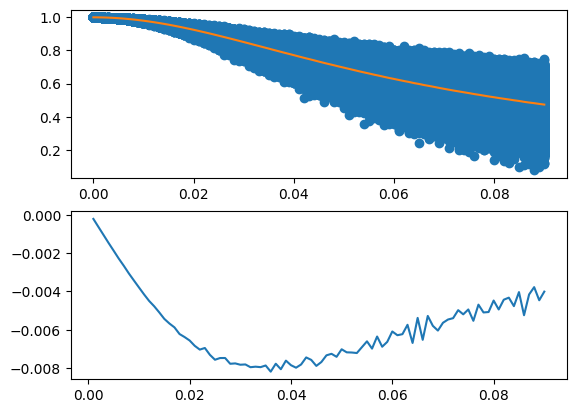

In [ ]:
plt.subplot(211)
plt.plot(Data2.iloc[:,1], Data2.iloc[:,2], 'o')
plt.plot(Data2.groupby(1).mean().index, Data2.groupby(1).mean().iloc[:,1])
plt.subplot(212)
plt.plot(Data2.groupby(1).mean().index, Data2.groupby(1).mean().iloc[:,1].diff())

## How many MC is needed?

In [ ]:
Data_pivoted = Data2.pivot_table(index = 0, columns  = 1)
#Data_pivoted['idx'] = Data_pivoted.index

In [ ]:
Data_pivoted.shape

(100000, 91)

In [ ]:
Data_pivoted = Data_pivoted[Data_pivoted>=.5].dropna(axis = 1).copy()
Data_pivoted.shape

(100000, 47)

In [ ]:
Data_pivoted.head()

2                                                              \
1   0.000     0.001     0.002     0.003     0.004     0.005     0.006   
0                                                                       
0.0   1.0  0.999805  0.998827  0.998289  0.996746  0.993836  0.993902   
1.0   1.0  0.999780  0.999218  0.998635  0.996777  0.995443  0.992647   
2.0   1.0  0.999866  0.998870  0.998330  0.996870  0.995062  0.992731   
3.0   1.0  0.999810  0.999242  0.998135  0.997186  0.995312  0.993930   
4.0   1.0  0.999809  0.999208  0.998253  0.996321  0.994686  0.992646   

                                   ...                                \
1       0.007     0.008     0.009  ...     0.037     0.038     0.039   
0                                  ...                                 
0.0  0.988110  0.990411  0.981303  ...  0.798290  0.787453  0.809681   
1.0  0.991436  0.988037  0.983005  ...  0.788630  0.798080  0.835147   
2.0  0.988101  0.991766  0.983340  ...  0.764001  0.817565  0.805161   
3.0  0.989956  0.982976  0.983322  ...  0.843747  0.815279  0.783924   
4.0  0.987290  0.984477  0.980912  ...  0.790163  0.772826  0.777706   

                                                                           
1       0.040     0.041     0.042     0.043     0.044     0.045     0.047  
0                                                                          
0.0  0.761463  0.746601  0.748645  0.703043  0.740610  0.757397  0.727094  
1.0  0.787380  0.812435  0.733404  0.742522  0.783485  0.737550  0.748887  
2.0  0.767088  0.677366  0.790101  0.800758  0.710103  0.764126  0.647139  
3.0  0.831631  0.786632  0.751628  0.766320  0.766751  0.713480  0.732126  
4.0  0.783046  0.813574  0.770574  0.705354  0.708718  0.751183  0.733226  

[5 rows x 47 columns]

In [ ]:

grid_range = np.arange(30, 100000, 30)
cv = np.zeros((len(grid_range),47))
sd = np.zeros_like(cv)
avg = np.zeros_like(cv)
for i in np.arange(47):
  k = 0
  #print(i)
  for j in grid_range:
    #print(i)
    #print(j)
    data = []
    data = Data_pivoted.iloc[0:j,i].values
    #print(data[-1])
    '''print(k)
    print(j)
    print(i)'''
    cv[k, i] = np.std(data)/np.mean(data)
    sd[k, i] = np.std(data)
    avg[k, i] = np.mean(data)
    k = k+1

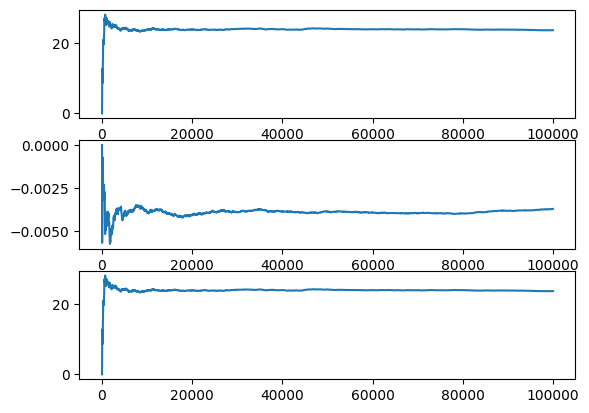

In [ ]:
run_number = 4#np.arange(5)
plt.subplot(311)
plt.plot(grid_range, 100*(cv[:,run_number]-cv[0,run_number])/cv[0,run_number])

plt.subplot(312)
plt.plot(grid_range, 100*(avg[:,run_number]-avg[0,run_number])/avg[0,run_number])

plt.subplot(313)
plt.plot(grid_range, 100*(sd[:,run_number]-sd[0,run_number])/sd[0,run_number])

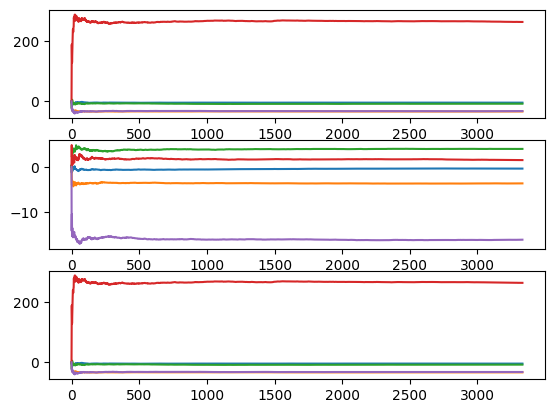

In [ ]:
run_number = np.arange(5)
diff_cv = np.diff(cv)
diff_avg = np.diff(avg)
diff_sd = np.diff(sd)
plt.subplot(311)
plt.plot(100*(diff_cv[:,run_number]-diff_cv[0,run_number])/diff_cv[0,run_number],'-')

plt.subplot(312)
plt.plot(100*(diff_avg[:,run_number]-diff_avg[0,run_number])/diff_avg[0,run_number],'-')

plt.subplot(313)
plt.plot(100*(diff_sd[:,run_number]-diff_sd[0,run_number])/diff_sd[0,run_number],'-')

In [ ]:
iter_num = (1.96*0.04/(.017)**2)**2
iter_num

73592.98858969597

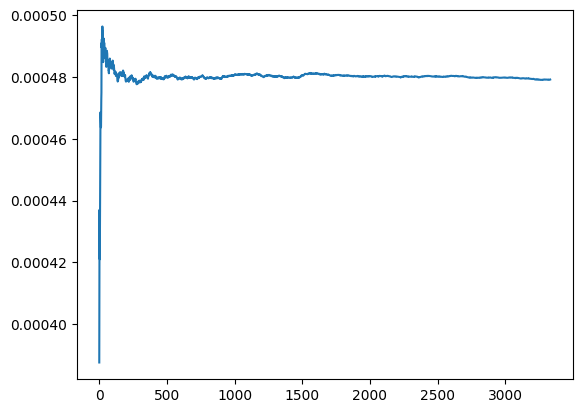

In [ ]:
plt.plot(pd.DataFrame(cv).iloc[:,4])


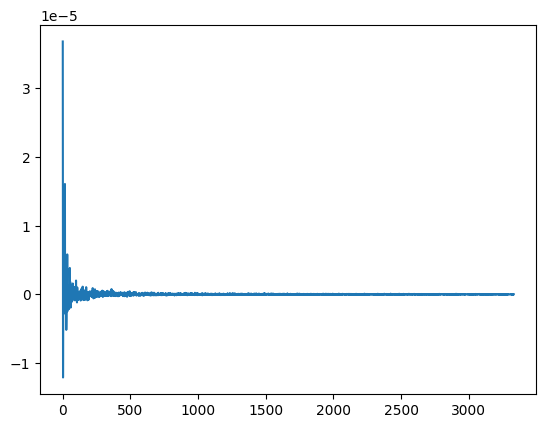

In [ ]:
plt.plot(pd.DataFrame(cv).iloc[:,4].diff())


# part 2: PINN
The produced data from `part1` were used fo rthis part.

I defined a custom cost function to use the Paejca function as well.

The model still needs to be tune, but it's topology design is almost done.



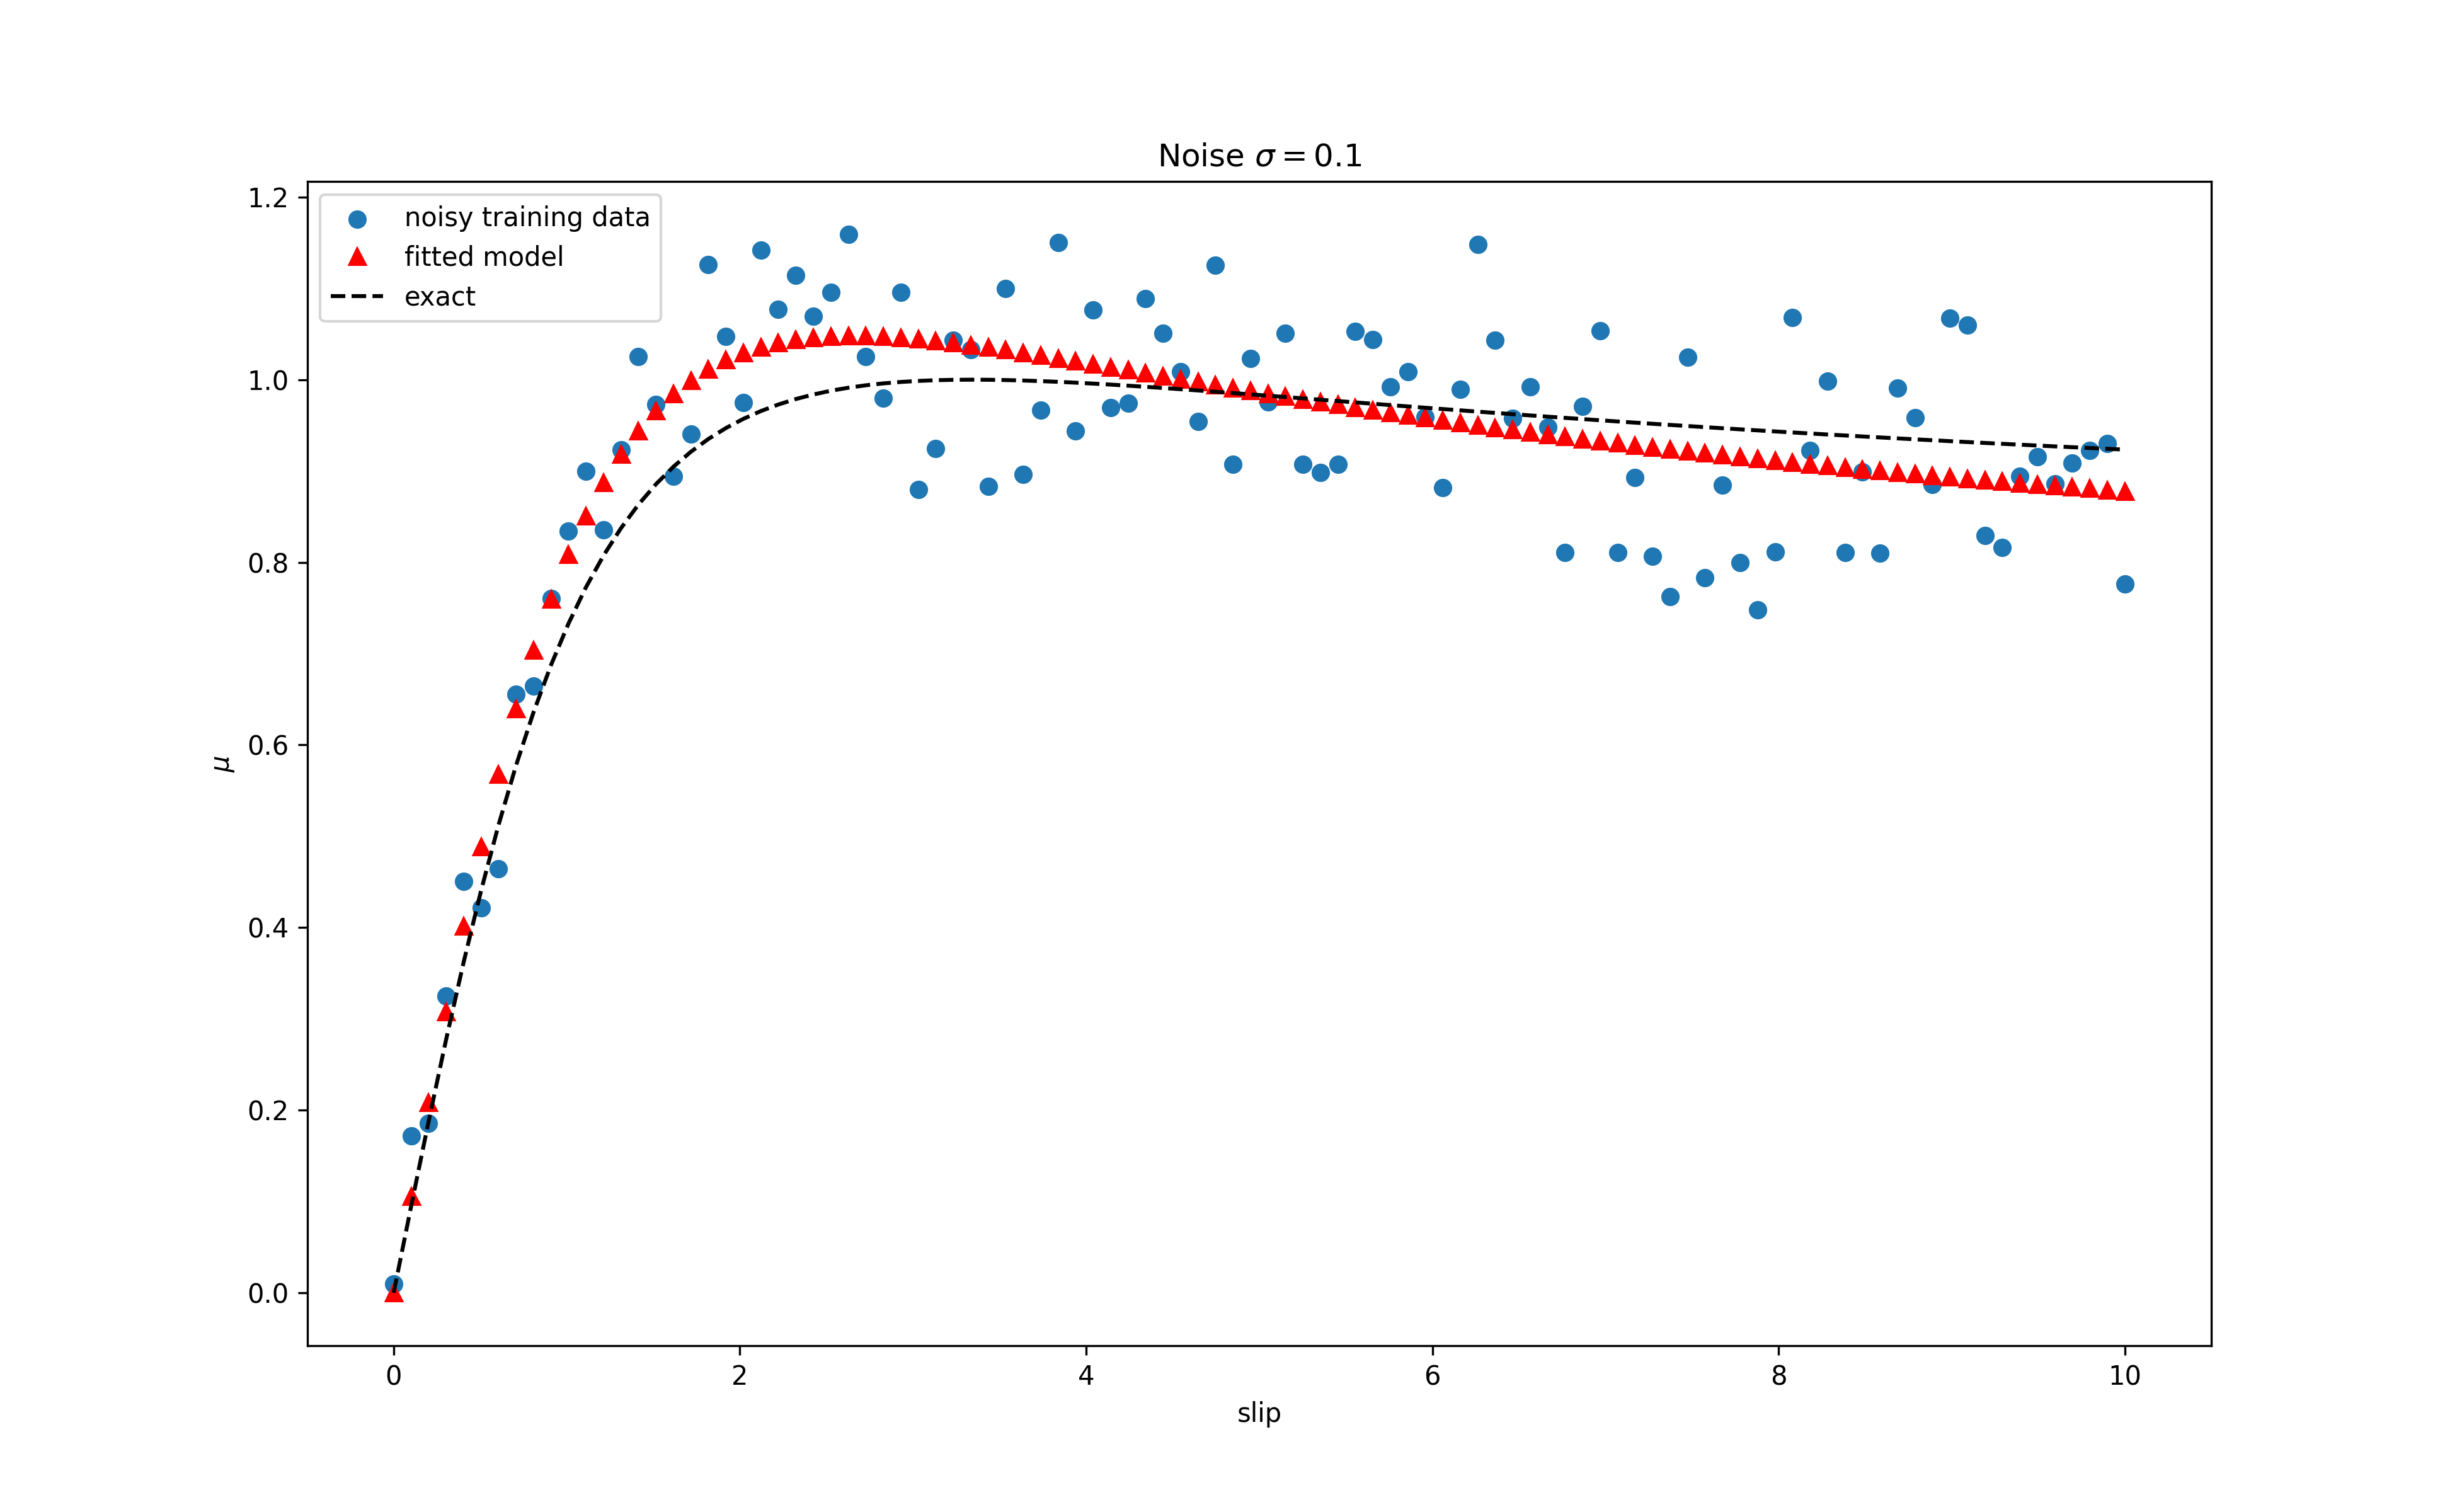

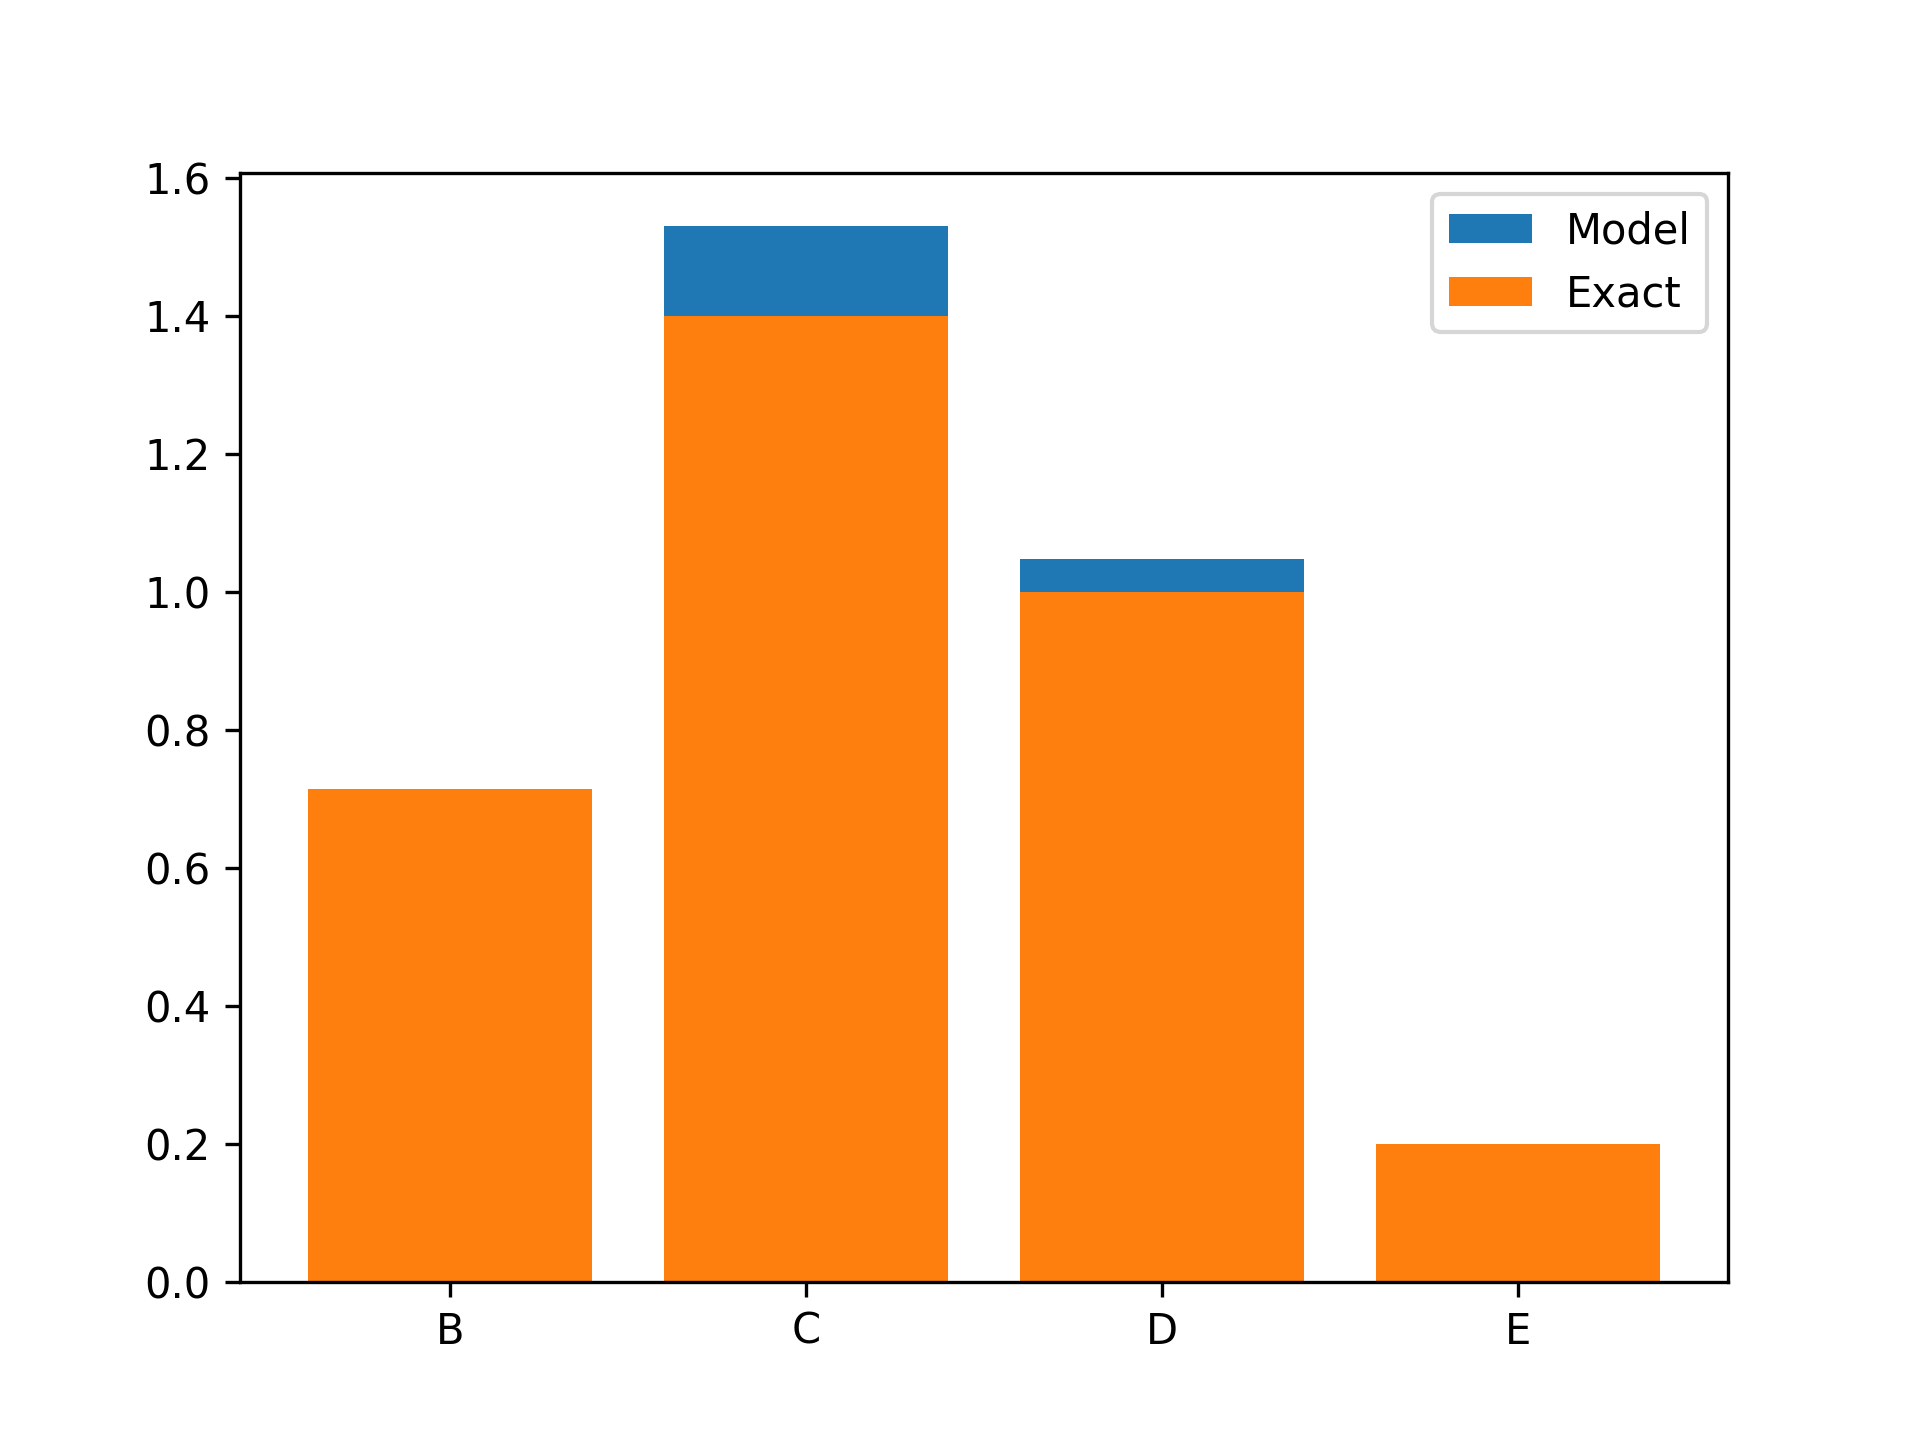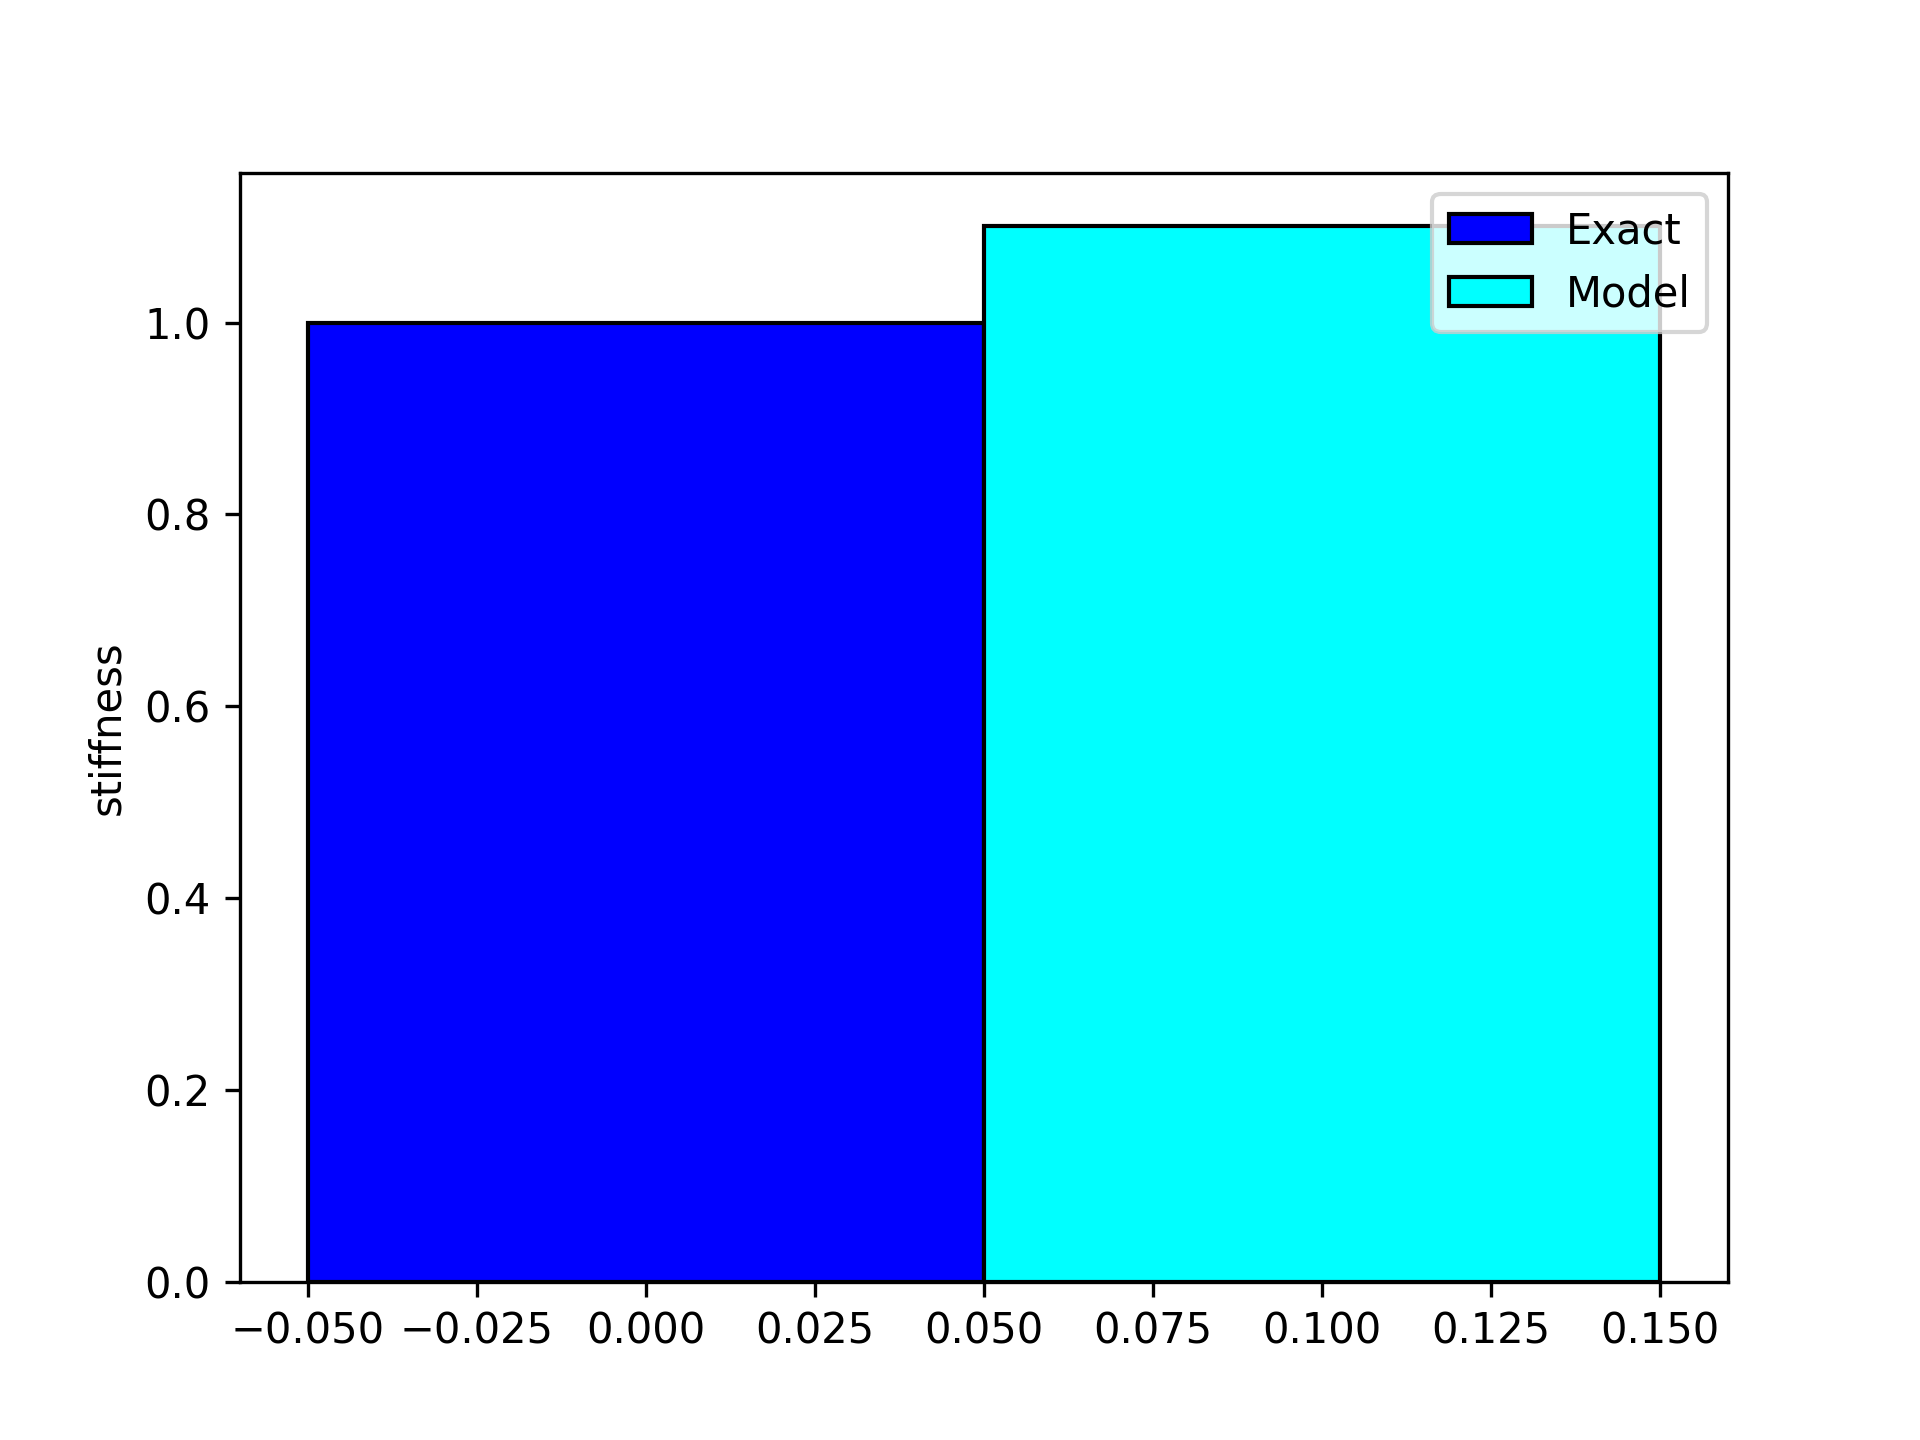

/bin/bash: -c: line 1: syntax error near unexpected token `Barplot-Params.png'
/bin/bash: -c: line 1: `[picture](Barplot-Params.png)'


In [ ]:
%% MF Fit - Summer 19 inch



slip_angle = (0:1/10:18); % Slip angle deg
magic_formula = @(x,slip_angle) (x(3).*sin(x(2).*atan(x(1).*(slip_angle+x(5))-x(4)*(x(1).*(slip_angle+x(5))-atan(x(1).*(slip_angle+x(5)))))));





% p_fit= B,C,D,E, Sh (horizontal shift)





figure(10000)
clf
hFig = figure(10000);
set(hFig, 'Position', [200 100 900 500])
set(gcf,'name','Axle Fits','numbertitle','off')
grid on
hold on
% Dry
p_fit = [11.8*pi/180;1.5772;9517/1149/9.81;-0.34;0];
mu_dry=magic_formula(p_fit,slip_angle);
plot(slip_angle,mu_dry,'k-','Linewidth',1.5)

References: 1.Gustafsson, Fredrik. "Monitoring tire-road friction using the wheel slip." IEEE Control Systems Magazine 18, no. 4 (1998): 42-49.

●

2.Miller, Shannon L., Brett Youngberg, Alex Millie, Patrick Schweizer, and J. Christian Gerdes. "Calculating longitudinal wheel slip and tire parameters using GPS velocity." In Proceedings of the 2001 American Control Conference.(Cat. No. 01CH37148), vol. 3, pp. 1800-1805. IEEE, 2001.

●

3.Pavković, Danijel, Joško Deur, Jahan Asgari, and Davor Hrovat. "Experimental analysis of potentials for tire friction estimation in low-slip operating mode." SAE Transactions (2006): 369-380.

●

4.Karjalainen, Max. "Real-time estimation of tire stiffness." (2016).

●

5.Braz, Joao Paulo P. "A Novel Road Grip Estimation Method Using a Vehicle as a Probe." PhD diss., 2019.

●

6.Raste, Thomas, Peter Lauer, and Bernd Hartmann. "Development of a Road Condition Observer for the “Vehicle Motion Control” Project." In XXXVII. Internationales μ-Symposium 2018 Bremsen-Fachtagung, pp. 127-141. Springer Vieweg, Berlin, Heidelberg, 2019.

●

7.Magnusson, Per, Hakan Frank, Torbjörn Gustavsson, and Esben Almkvist. "Real-time high-resolution road condition map for the EU." In 9th International Munich Chassis Symposium 2018, pp. 851-875. Springer Vieweg, Wiesbaden, 2019.

In [ ]:
k = 32
capacity = 8
hash = k% capacity
stepSize = (( (k/capacity) % (capacity/2) ) * 2) + 1

(hash + stepSize) % capacity

1.0

In [ ]:
import numpy as np
import matplotlib.pylab as plt

In [ ]:
x = np.linspace(0,1000)

In [ ]:
f1 = (np.log(x))**2
f2 = x*np.log(np.log(x))
f3 = (x**.5)*np.log(x)
f4 = 7*(x**.5)
f5 = 9*x*np.log(x)
f6 = x**2

<ipython-input-8-1ada1b684b4c>:1: RuntimeWarning: divide by zero encountered in log
  f1 = (np.log(x))**2
<ipython-input-8-1ada1b684b4c>:2: RuntimeWarning: divide by zero encountered in log
  f2 = x*np.log(np.log(x))
<ipython-input-8-1ada1b684b4c>:2: RuntimeWarning: invalid value encountered in log
  f2 = x*np.log(np.log(x))
<ipython-input-8-1ada1b684b4c>:3: RuntimeWarning: divide by zero encountered in log
  f3 = (x**.5)*np.log(x)
<ipython-input-8-1ada1b684b4c>:3: RuntimeWarning: invalid value encountered in multiply
  f3 = (x**.5)*np.log(x)
<ipython-input-8-1ada1b684b4c>:5: RuntimeWarning: divide by zero encountered in log
  f5 = 9*x*np.log(x)
<ipython-input-8-1ada1b684b4c>:5: RuntimeWarning: invalid value encountered in multiply
  f5 = 9*x*np.log(x)


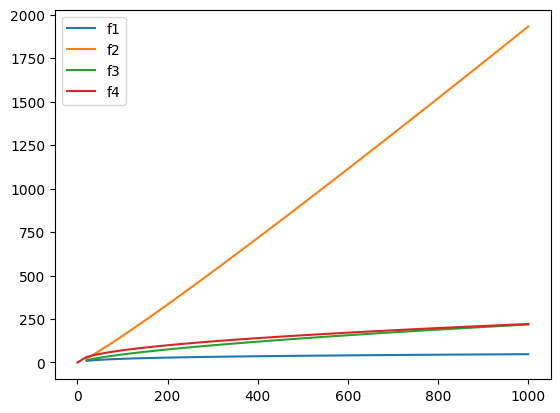

In [ ]:
plt.plot(x, f1)
plt.plot(x, f2)
plt.plot(x, f3)
plt.plot(x, f4)
#plt.plot(x, f5)
#plt.plot(x, f6)
plt.legend(['f1', 'f2', 'f3', 'f4'])
#plt.xlim([0,50])